# Проєкт з лінійної алгебри

## **Face Recognition**

---

### Команда

- **Семсічко Лідія**  
- **Білий Андрій**  
- **Сампара Софія**

In [1]:
# import libraries
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from numpy.linalg import norm

### Preprocessing: Face Detection and Cropping

The `center_and_crop_face` function performs the **preprocessing stage** of the face recognition algorithm. Its main goal is to standardize input images by:

- Detecting the face automatically,
- Centering the face within the frame,
- Cropping the image to a fixed size (400 × 400 pixels),
- Converting the image to grayscale.

This normalization step ensures consistency across all input data, reducing the influence of:

- Background noise,
- Lighting and color variations,
- Face position and scale.

As a result, the processed images are more suitable for further analysis, training, or classification in the recognition pipeline.


In [2]:
def center_and_crop_face(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) == 0:
        print(f"Не знайдено обличчя на фото {image_path}")
        return None

    x, y, w, h = faces[0]
    face_center = (x + w // 2, y + h // 2)
    size = 400
    start_x = max(face_center[0] - size // 2, 0)
    start_y = max(face_center[1] - size // 2, 0)
    cropped_img = img[start_y:start_y + size, start_x:start_x + size]
    gray_cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    return gray_cropped_img

### Image Preprocessing Pipeline: Batch Processing and Organization

This part of the algorithm performs **batch preprocessing** of face images stored in the `training_data` folder. It includes detection, cropping, grayscale conversion, and saving the processed images in a structured manner. The steps are as follows:

1. **Create output folders:**  
   If the main output directory (`output_images`) does not exist, it is created.

2. **Iterate through all `.jpg` images:**  
   Each image is passed through the `center_and_crop_face` preprocessing function. Images where no face is detected are skipped.

3. **Classify and organize images by name:**  
   The filename is checked for the presence of any known person’s name (`andrii`, `lida`, `sofia`).  
   - If a name is found, the image is saved to the corresponding subfolder.  
   - If no known name is found, the image is categorized under `others`.

4. **Save processed images:**  
   Each preprocessed image is saved with the prefix `processed_` into the appropriate subfolder within `output_images`.

This pipeline allows efficient preparation of a labeled dataset for training a face recognition model, ensuring all images are standardized and organized by individual.


In [3]:
input_folder = "training_data"
output_folder = "output_images"
names = ["andrii", "lida", "sofia"]

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(input_folder, filename)
        processed_img = center_and_crop_face(image_path)

        if processed_img is not None:
            folder_name = None
            for name in names:
                if name in filename.lower():
                    folder_name = name
                    break

            if folder_name is None:
                folder_name = "others"

            output_subfolder = os.path.join(output_folder, folder_name)
            if not os.path.exists(output_subfolder):
                os.makedirs(output_subfolder)

            output_filename = f"processed_{filename}"
            output_path = os.path.join(output_subfolder, output_filename)
            cv2.imwrite(output_path, processed_img)


The `load_images_from_folder` function is used to load grayscale images from directory and convert them into numpy arrays suitable for numerical processing. It reads and sorts all filenames in the given folder, then attempts to open each image using PIL library. Each image is converted to grayscale to reduce dimensionality and standardize input format. If a target image size is provided, the image is resized accordingly. After conversion, each image is transformed into a numpy array of type `float64`, which allows for precise numerical computations. Images that cannot be loaded are skipped, and an error message is printed for each failed attempt. The function returns a list of all successfully processed image arrays, forming the basis for further analysis in the face recognition pipeline.


In [4]:

def load_images_from_folder(folder, image_size=None):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        filepath = os.path.join(folder, filename)
        try:
            img = Image.open(filepath).convert('L')
            if image_size is not None:
                img = img.resize(image_size)
            img_array = np.array(img, dtype=np.float64)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
    return images


This block prepares the training dataset for the face recognition algorithm. It loads all preprocessed grayscale face images from the `output_images` directory, groups them by subject (i.e., individual identity), and ensures they all share the same dimensions. Each image is then flattened into a one-dimensional vector, and all such vectors are stacked column-wise to form a data matrix suitable for linear algebra operations.

The resulting matrix `all_faces` contains one column per image, where each column represents a face as a high-dimensional vector. This format is essential for applying dimensionality reduction techniques such as Principal Component Analysis (PCA), which is commonly used in face recognition systems to extract key features and reduce noise or redundancy in the data.

In parallel, the list `labels` keeps track of the identity associated with each column (image) in the matrix. Together, `all_faces` and `labels` serve as the core dataset for training or evaluating the recognition model.


In [5]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})



dataset_path = 'output_images'
subjects = os.listdir(dataset_path)
subjects = [s for s in subjects if os.path.isdir(os.path.join(dataset_path, s))]
subject_images = {}
sample_img = load_images_from_folder(os.path.join(dataset_path, subjects[0]))

if len(sample_img) == 0:
    raise ValueError("No images found in the first subject folder.")
img_shape = sample_img[0].shape


print("Image size:", img_shape)


for subject in subjects:
    folder = os.path.join(dataset_path, subject)
    imgs = load_images_from_folder(folder, image_size=img_shape)
    if len(imgs) > 0:
        subject_images[subject] = imgs


all_faces = []
labels = []
for subject, imgs in subject_images.items():
    for img in imgs:
        all_faces.append(img.flatten())
        labels.append(subject)

all_faces = np.array(all_faces).T
print("Training data matrix shape:", all_faces.shape)

Image size: (400, 400)
Training data matrix shape: (160000, 80)


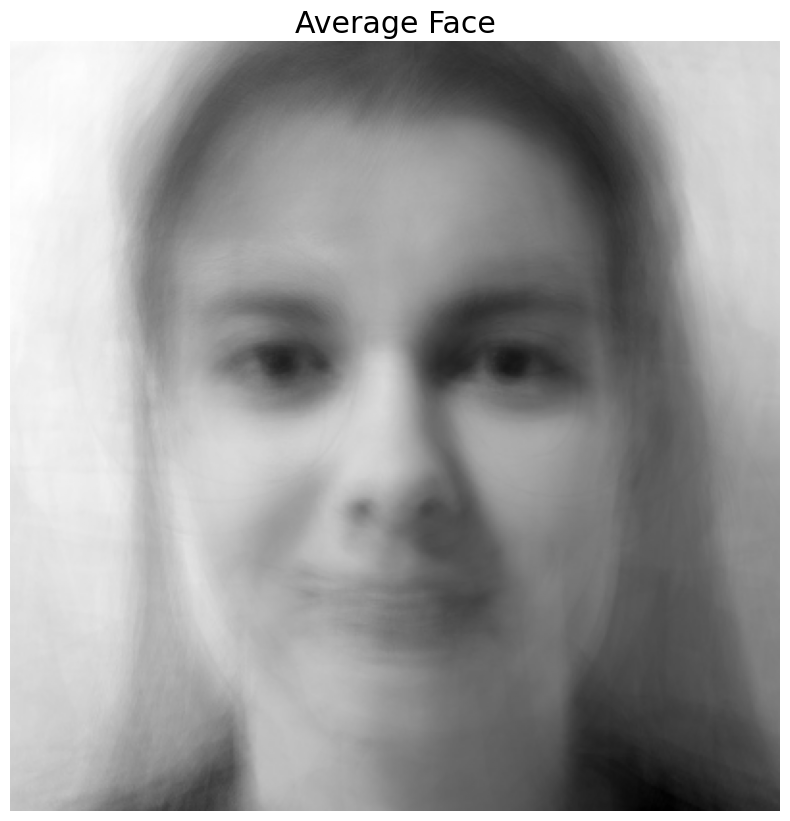

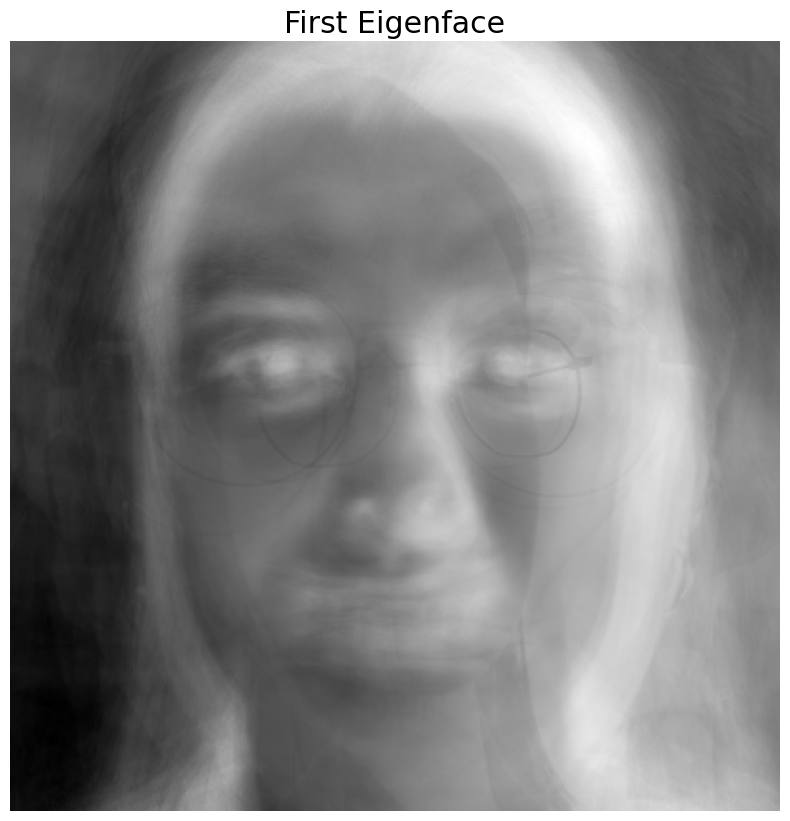

In [6]:
avg_face = np.mean(all_faces, axis=1).reshape(-1, 1)
X = all_faces - np.tile(avg_face, (1, all_faces.shape[1]))

XtX = np.dot(X.T, X)
# print(XtX.size)

def power_method(A, max_iter=1000, tol=1e-6):
    x = np.random.rand(A.shape[1])
    x = x / np.linalg.norm(x)
    for _ in range(max_iter):
        x_new = A @ x
        x_new /= np.linalg.norm(x_new)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    # eigenvalue = x.T @ A @ x
    return x

def top_k_eigenvectors(A, k):
    eigvecs = []
    for _ in range(k):
        v = power_method(A)
        eigvecs.append(v)
        A = A - np.outer(v, A @ v)  # deflation
    return np.stack(eigvecs, axis=1)

eigvecs = top_k_eigenvectors(XtX, 20)

U_custom = np.dot(X, eigvecs)
eigenfaces = U_custom / np.linalg.norm(U_custom, axis=0)
# U, s, Vt = np.linalg.svd(X, full_matrices=False)

# eigenfaces = U
plt.figure()
plt.imshow(avg_face.reshape(img_shape), cmap='gray')
plt.title("Average Face")
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(eigenfaces[:,0].reshape(img_shape), cmap='gray')
plt.title("First Eigenface")
plt.axis('off')
plt.show()

True
Predicted subject: andrii (True subject: sofia)


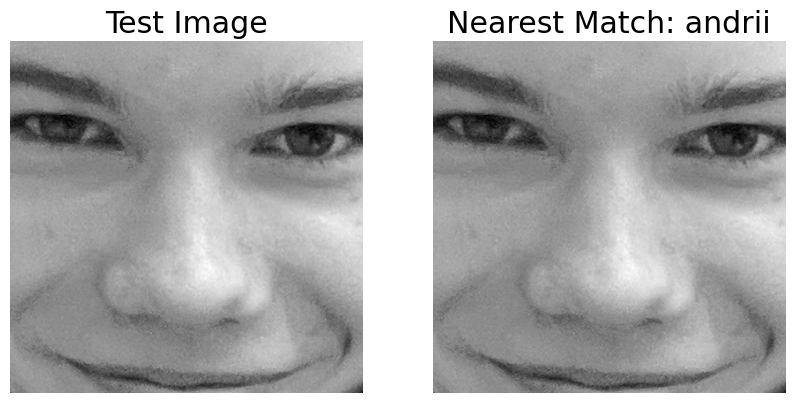

In [7]:
proj_train = eigenfaces.T @ X

def classify_face(test_img, avg_face, eigenfaces, proj_train, labels):
    """
    Given a test image (2D array), subtract the average face, project onto
    eigenfaces, and classify by nearest neighbor in eigenface space.
    """
    test_vector = test_img.flatten().reshape(-1, 1)
    test_vector_centered = test_vector - avg_face
    proj_test = eigenfaces.T @ test_vector_centered

    distances = norm(proj_train - proj_test, axis=0)
    best_match_index = np.argmin(distances)
    predicted_label = labels[best_match_index]
    return predicted_label, distances[best_match_index], proj_test

demo_subject = "sofia"
image_path = "training_data/andrii (22).jpg"
print(os.path.exists(image_path))
demo_img = center_and_crop_face(image_path)
predicted_label, distance, proj_test = classify_face(demo_img, avg_face, eigenfaces, proj_train, labels)
print(f"Predicted subject: {predicted_label} (True subject: {demo_subject})")

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(demo_img, cmap='gray')
plt.title("Test Image")
plt.axis('off')

best_match_vector = all_faces[:, np.argmin(norm(proj_train - proj_test, axis=0))]
best_match_img = best_match_vector.reshape(img_shape)
plt.subplot(1,2,2)
plt.imshow(best_match_img, cmap='gray')
plt.title(f"Nearest Match: {predicted_label}")
plt.axis('off')

plt.show()

### Visualization

This section is dedicated to **illustrate** our results in detecting faces. Here are listed plot types, such as:
- Scree Plot;
- Diagram of Cumulative Variance;
- 2D Projection of 1st and 2nd Principal Components;
- List of Eigenfaces;
- Similarity Matrix

These diagrams will provide you with sufficient information on how we **constructed** our face recognition configurations and will help with **understanding the concept**


First of all we want to find all of our eigenvectors and their corresponding eigenvalues which we will use in the future visualizations. We find eigenvectors using our `top_k_eigenvectors`. Then we normalize them and find our eigenfaces. Then by multiplying each eigenface with covarince matrix and by transpose of v we can find our eigenvalues.

In [8]:
eigvecs_diagram = top_k_eigenvectors(XtX, all_faces.shape[1])

U_custom_diagram = np.dot(X, eigvecs_diagram)
eigenfaces_diagram = U_custom_diagram / np.linalg.norm(U_custom_diagram, axis=0)

eigenvalues = []
for i in range(eigvecs_diagram.shape[1]):
    v = eigvecs_diagram[:, i]
    eigenvalue = np.dot(v.T, np.dot(XtX, v))
    eigenvalues.append(eigenvalue)

eigenvalues = np.array(eigenvalues)


sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]

The following plot is a simple **scree** diagram, which shows how much variance is explained by principal components. This is a **crucial illustration**, because it gives us info on **how many principal components** is enough to perform face recognition efficiently. On the X-axis is the number of principal components and on the Y-direction is the eigenvalues sorted in descending order (the first one is the biggest). As you can obeserve, starting from the 20th principal component the difference between the next and the previous PC is almost negligible, which we will definetely take in consideration.

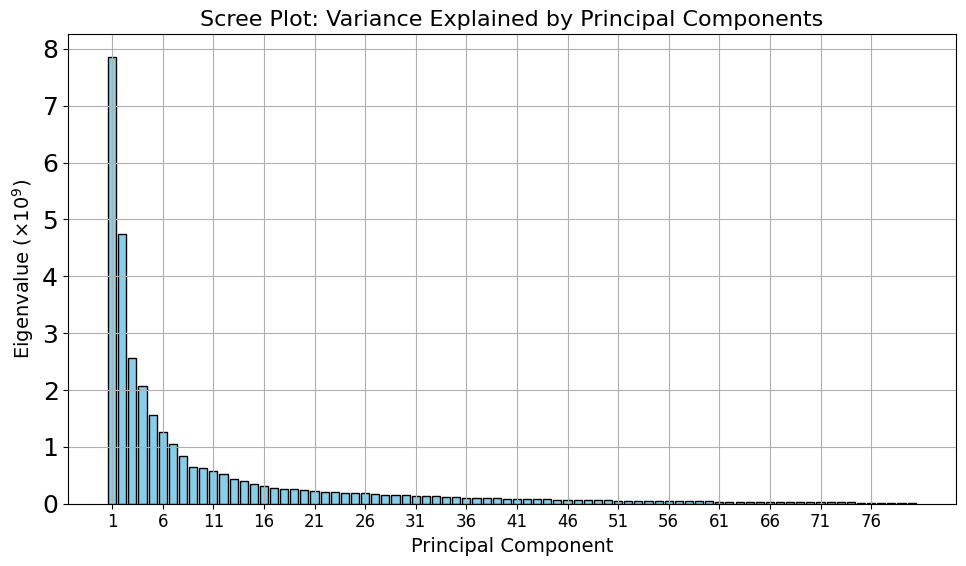

In [9]:
"""Scree Plot"""

import matplotlib.ticker as mtick

plt.figure(figsize=(10, 6))
component_indices = np.arange(1, len(eigenvalues) + 1)
plt.bar(component_indices, eigenvalues, color='skyblue', edgecolor='black')


ax = plt.gca()
formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.yaxis.set_major_formatter(formatter)


plt.draw()
offset_text = ax.yaxis.get_offset_text().get_text()


plt.title("Scree Plot: Variance Explained by Principal Components", fontsize=16)
plt.xlabel("Principal Component", fontsize=14)
plt.ylabel(f"Eigenvalue ({offset_text})", fontsize=14)


ax.yaxis.get_offset_text().set_visible(False)


if len(component_indices) > 20:
    plt.xticks(component_indices[::5], fontsize=12)
else:
    plt.xticks(component_indices, fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


To futher understand how many principal components are enought for our process we also plotted **cumulative version** of the previous graph. On the X-Axis is number of principal components and on the Y-Axis is the percentage of variance explained. Here you can see that **90 percent** of all variance can be deduced only using **26 PCs** instead of using all 80+ eigenfaces. And this is pretty neat, as it decreases our computation complexities and provides a good variance explanation. This graph is depicted by finding the cumulative sums of the eigenvalues using `np.cumsum` function then this value is divided my the sum of eigenvalues and multiplied by 100 to get the percent metric.

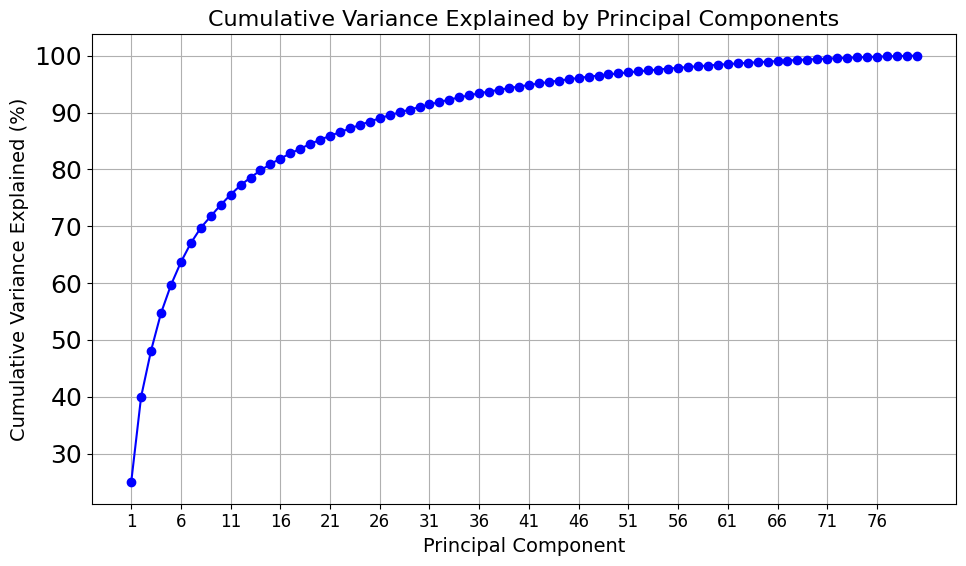

In [10]:
"""Cumulative Variance Explained Plot"""

cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues) * 100


plt.figure(figsize=(10, 6))
component_indices = np.arange(1, len(eigenvalues) + 1)
plt.plot(component_indices, cumulative_variance, marker='o', linestyle='-', color='blue')


plt.title("Cumulative Variance Explained by Principal Components", fontsize=16)
plt.xlabel("Principal Component", fontsize=14)
plt.ylabel("Cumulative Variance Explained (%)", fontsize=14)


if len(component_indices) > 20:
    plt.xticks(component_indices[::5], fontsize=12)
else:
    plt.xticks(component_indices, fontsize=12)

plt.grid(True)

plt.tight_layout()
plt.show()

Next we decided to simulate face recognition process using the 2D scatter plot of the first two principal components. On the x-direction is the first PC and on the other axis is the 2nd one respectively. On this graph you can clearly see the location of every picture from the training set and the new image we need to classify. How it is done? It finds the indices of the samples that belong to that subject. Then it plots the corresponding points from `proj_train`, which holds the first two principal components for the training data.

/var/folders/tn/3745427x7rg89dq1v3tkkjtw0000gn/T/ipykernel_11993/2552290408.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_labels))


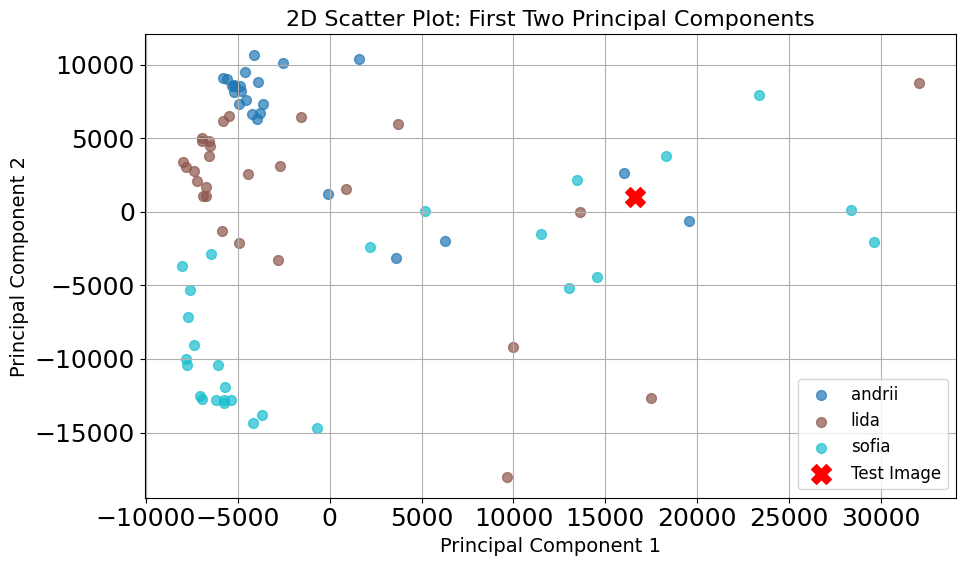

In [11]:
"""2D projection of 1st and 2nd Principal Components"""

plt.figure(figsize=(10, 6))


unique_labels = np.unique(labels)

cmap = plt.cm.get_cmap('tab10', len(unique_labels))


for i, subject in enumerate(unique_labels):

    indices = [j for j, lab in enumerate(labels) if lab == subject]

    plt.scatter(proj_train[0, indices], proj_train[1, indices],
                color=cmap(i), label=subject, s=50, alpha=0.7)


if 'proj_test' in globals():
    plt.scatter(proj_test[0], proj_test[1], color='red', marker='X', s=200, label='Test Image')


plt.title("2D Scatter Plot: First Two Principal Components", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)


plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

Then we want to show you which PCs are included in our process and how they look like. These images are taken from the `eigenfaces` variable and are reshaped to make them 2D. Each of this eigenface differs from one another and captures different variance, which is the cornerstone of our computations.

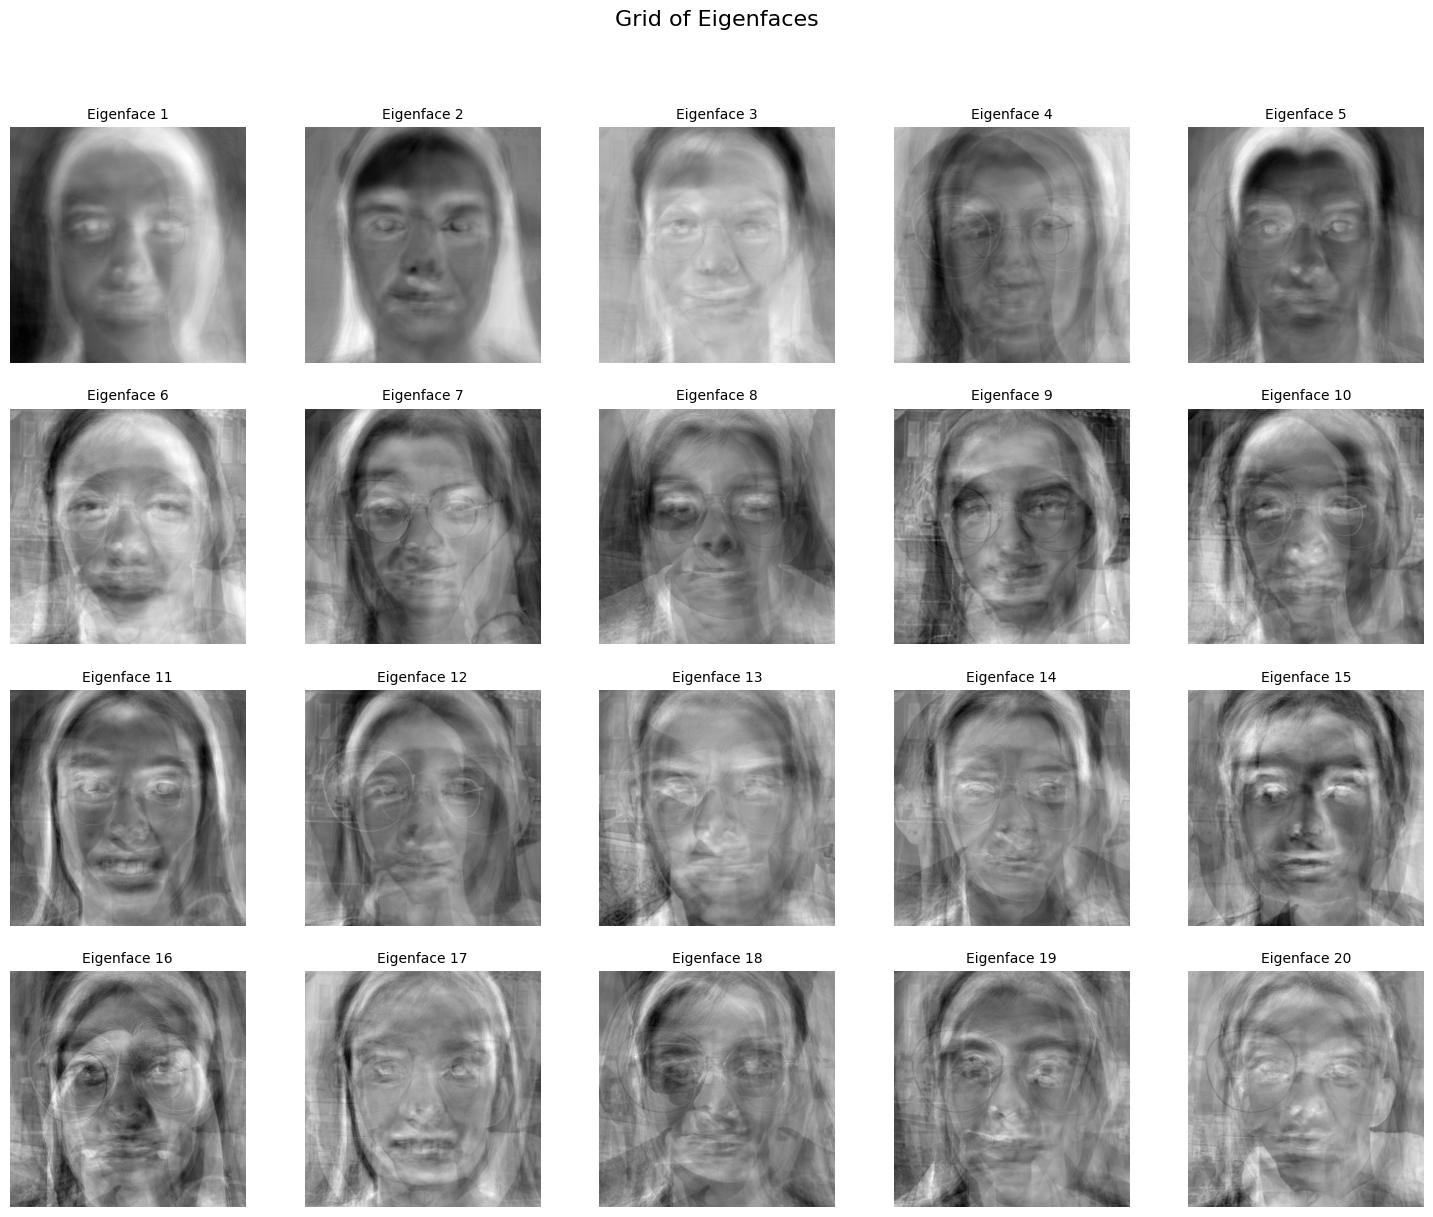

In [12]:
"""Some Eigenfaces"""

n_eigenfaces = eigenfaces.shape[1]


n_cols = 5
n_rows = int(np.ceil(n_eigenfaces / n_cols))

plt.figure(figsize=(15, 3 * n_rows))
for i in range(n_eigenfaces):
    ax = plt.subplot(n_rows, n_cols, i + 1)

    plt.imshow(eigenfaces[:, i].reshape(img_shape), cmap='gray')
    plt.title(f'Eigenface {i + 1}', fontsize=10)
    plt.axis('off')

plt.suptitle('Grid of Eigenfaces', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In this section we plot the **similarity matrix** to simulate the distance of projections of training images with each other onto the lower-dimensional space formerd by the principal components. On both axes is the set of all training images and the darker the area is, the smaller is the distance between projected vectors (training images), i.e. this images are very similiar. On contrary, brigther colors suggest that subjects are very different in the eigenface space. The main diagonal is black, becuase the distance of a vector to itself is 0 ($dist(v, v) = 0$)

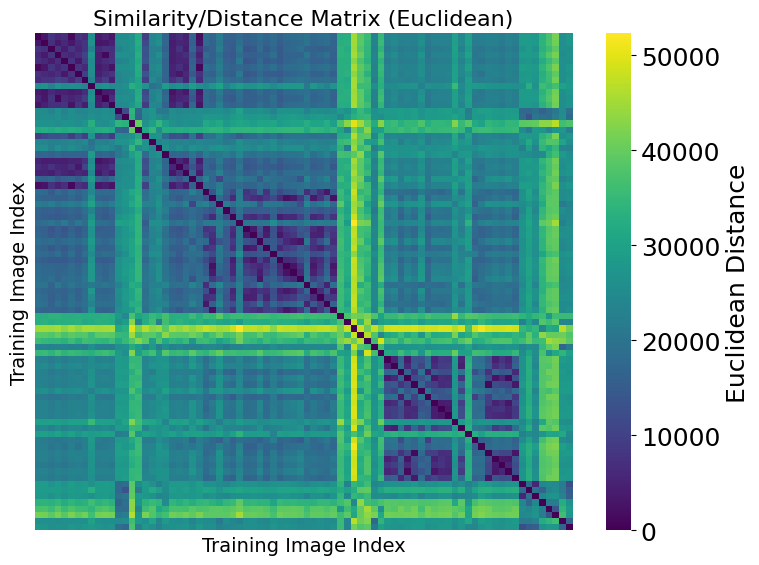

In [13]:
"""Similarity Matrix"""
import seaborn as sns
from scipy.spatial.distance import cdist


distance_matrix = cdist(proj_train.T, proj_train.T, metric='euclidean')

plt.figure(figsize=(8, 6))
sns.heatmap(distance_matrix, cmap='viridis',
            cbar_kws={'label': 'Euclidean Distance'},
            xticklabels=False, yticklabels=False)
plt.title("Similarity/Distance Matrix (Euclidean)", fontsize=16)
plt.xlabel("Training Image Index", fontsize=14)
plt.ylabel("Training Image Index", fontsize=14)
plt.tight_layout()
plt.show()


### Testing and Evaluation

This part of the code performs **face recognition testing** on a set of images from the `test/` folder. For each test image. The resulting image is then classified using the previously computed eigenfaces and projection data from the training set.

The predicted identity is compared with the true identity, which is inferred from the filename. Results are visualized in a grid of images, each annotated with its predicted label.

#### Thresholding

A threshold is used to distinguish between known and unknown faces based on the Euclidean distance between the projected test image and the closest training image in the PCA subspace. If the distance exceeds the threshold, the face is classified as `"UNKNOWN"`.

#### Choosing the Threshold

The choice of threshold is critical and can be tuned experimentally by:
- **Plotting distance distributions** of known and unknown samples.
- **Using a validation set** to test different thresholds and find the one that maximizes accuracy.

#### Factors Affecting Results

Several factors influence recognition performance:
- **Image quality and resolution**: Low-resolution or blurry images reduce feature clarity.
- **Lighting conditions**: Shadows and varying brightness can shift the appearance in PCA.
- **Face alignment and crop quality**: Inconsistent preprocessing can degrade accuracy.
- **Size and diversity of the training set**: More diverse examples per subject improve generalization.
- **Number of principal components (eigenfaces)** used: Too few may underfit; too many may overfit or amplify noise.

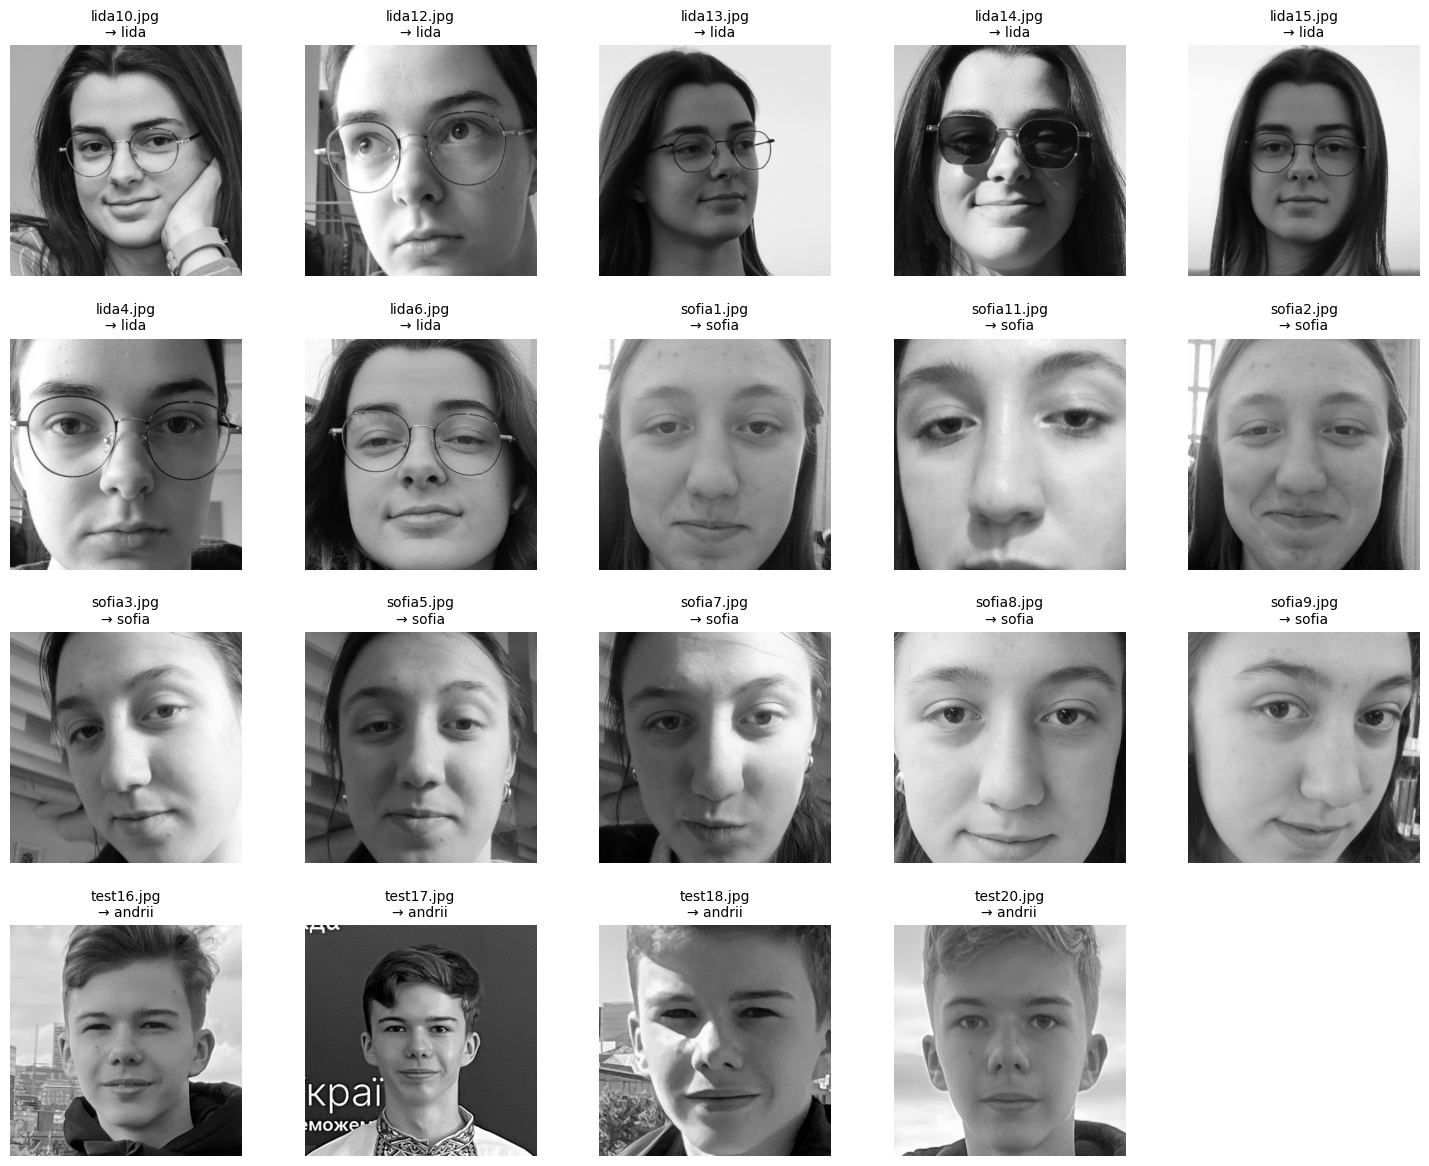

Accuracy: 78.95% (15 / 19)


In [14]:
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from numpy.linalg import norm

names = ["andrii", "lida", "sofia"]

def get_true_label_from_filename(filename, known_names):
    for name in known_names:
        if name in filename.lower():
            return name
    return "UNKNOWN"

test_folder = "test"
test_files = sorted([f for f in os.listdir(test_folder) if f.endswith(".jpg")])
threshold = 20000  # підібрати експериментально

true_labels = []
predicted_labels = []

n_cols = 5
n_rows = (len(test_files) + n_cols - 1) // n_cols
plt.figure(figsize=(15, 3 * n_rows))
grid = gridspec.GridSpec(n_rows, n_cols)

for idx, filename in enumerate(test_files):
    image_path = os.path.join(test_folder, filename)
    test_img = center_and_crop_face(image_path)
    if test_img is None:
        continue

    predicted_label, distance, proj_test = classify_face(test_img, avg_face, eigenfaces, proj_train, labels)

    if distance > threshold:
        predicted_text = "UNKNOWN"
    else:
        predicted_text = predicted_label

    true_label = get_true_label_from_filename(filename, names)
    true_labels.append(true_label)
    predicted_labels.append(predicted_text)

    title = f"{filename}\n→ {predicted_text}"

    ax = plt.subplot(grid[idx])
    ax.imshow(test_img, cmap='gray')
    ax.set_title(title, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

correct = sum(t == p for t, p in zip(true_labels, predicted_labels))
accuracy = correct / len(true_labels) * 100
print(f"Accuracy: {accuracy:.2f}% ({correct} / {len(true_labels)})")
